# Algerian Forest Fires

### Project Goals:

Given a set of forest fire data, we will attempt to understand what factors affect the likelyhood of a forestfire, as well as attempt create a model that predicts future forest fires

In [1]:
library(tidyverse)
library(tidymodels)
options(repr.matrix.max.rows = 8)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

The Algerian forest fire dataset contains data from two regions in Algeria, over the span of three months. It has collected the temperature, relative humidity (RH), wind speed (Ws), rainfall, find fuel moisture code (FFMC), drought code (DC), initial spread index (ISI), buildup index (BUI), and fire weather index (FWI). 

//TODO explain the less obvious columns

The data is already in a tidy format, with each row being a observation on a day.

As FFMC, DMC, DC, ISI, BUI and FWI are calculated using temperature, humidity, rainfal, and windspeed, we decided do only use these four as our ppredictors.

In [2]:
algerian_forest_fire_Bejaia <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/00547/Algerian_forest_fires_dataset_UPDATE.csv", 
                                 skip = 1, n_max = 122) %>%
    mutate(Region = "Bejaia")

algerian_forest_fire_Sidi_Bel_Abbes <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/00547/Algerian_forest_fires_dataset_UPDATE.csv",
                                               skip = 126) %>%
    mutate(Region = "Sidi Bel Abbes")

## Merge datasets

algeria_forest_fire_all_data <- rbind(algerian_forest_fire_Bejaia, algerian_forest_fire_Sidi_Bel_Abbes) %>%
    mutate(Classes = as_factor(Classes)) %>%
    mutate(Region = as_factor(Region))

algeria_forest_fire_all_data[166, 10] <- '14.6'
algeria_forest_fire_all_data[166, 11] <- 9
algeria_forest_fire_all_data[166, 12] <- 12.5
algeria_forest_fire_all_data[166, 13] <- '10.4'
algeria_forest_fire_all_data[166, 14] <- "fire" 

#remove row with error
algeria_forest_fire_all_data <- algeria_forest_fire_all_data[-c(166),] %>%
   mutate(DC = as.numeric(DC)) %>%
   mutate(FWI = as.numeric(FWI))



algeria_forest_fire_all_data

Parsed with column specification:
cols(
  day = col_character(),
  month = col_character(),
  year = col_double(),
  Temperature = col_double(),
  RH = col_double(),
  Ws = col_double(),
  Rain = col_double(),
  FFMC = col_double(),
  DMC = col_double(),
  DC = col_double(),
  ISI = col_double(),
  BUI = col_double(),
  FWI = col_double(),
  Classes = col_character()
)

Parsed with column specification:
cols(
  day = col_character(),
  month = col_character(),
  year = col_double(),
  Temperature = col_double(),
  RH = col_double(),
  Ws = col_double(),
  Rain = col_double(),
  FFMC = col_double(),
  DMC = col_double(),
  DC = col_character(),
  ISI = col_double(),
  BUI = col_double(),
  FWI = col_character(),
  Classes = col_character()
)

Warning message:
“1 parsing failure.
row col   expected     actual                                                                                                       file
 44  -- 14 columns 13 columns 'https://archive.ics.uci.edu/ml/machine-lear

day,month,year,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes,Region
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>
01,06,2012,29,57,18,0.0,65.7,3.4,7.6,1.3,3.4,0.5,not fire,Bejaia
02,06,2012,29,61,13,1.3,64.4,4.1,7.6,1.0,3.9,0.4,not fire,Bejaia
03,06,2012,26,82,22,13.1,47.1,2.5,7.1,0.3,2.7,0.1,not fire,Bejaia
04,06,2012,25,89,13,2.5,28.6,1.3,6.9,0.0,1.7,0.0,not fire,Bejaia
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
27,09,2012,28,87,15,4.4,41.1,6.5,8.0,0.1,6.2,0.0,not fire,Sidi Bel Abbes
28,09,2012,27,87,29,0.5,45.9,3.5,7.9,0.4,3.4,0.2,not fire,Sidi Bel Abbes
29,09,2012,24,54,18,0.1,79.7,4.3,15.2,1.7,5.1,0.7,not fire,Sidi Bel Abbes
30,09,2012,24,64,15,0.2,67.3,3.8,16.5,1.2,4.8,0.5,not fire,Sidi Bel Abbes


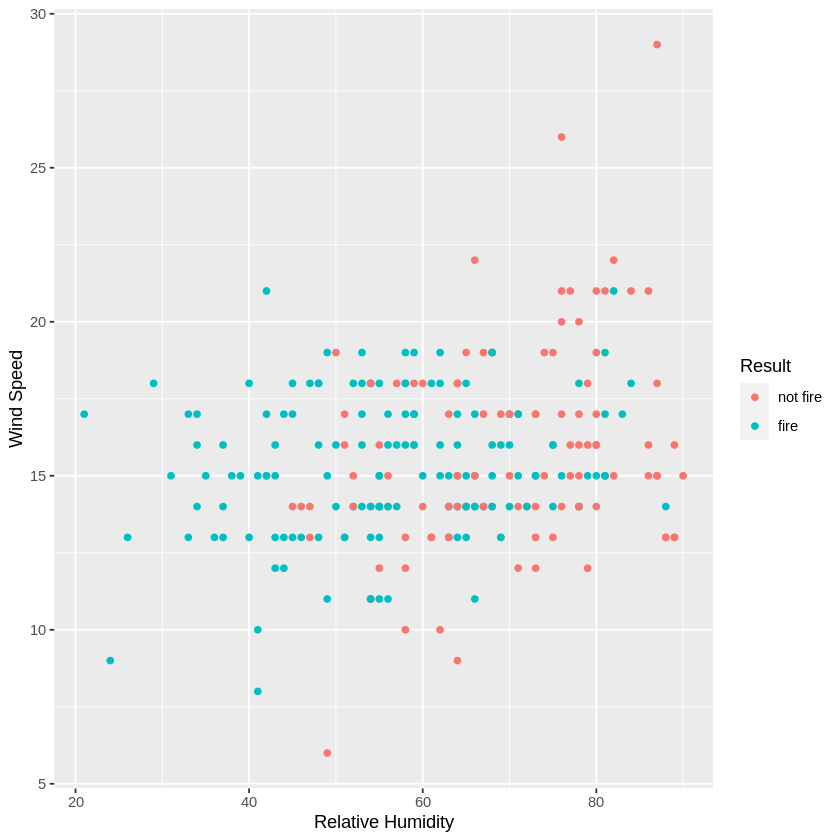

In [3]:
humidity_v_wind_speed <- algeria_forest_fire_all_data %>%
    ggplot(aes(x = RH, y = Ws, color = Classes)) + 
    geom_point() +
    labs (x = "Relative Humidity", y = "Wind Speed", color = "Result") #weird title for color

humidity_v_wind_speed

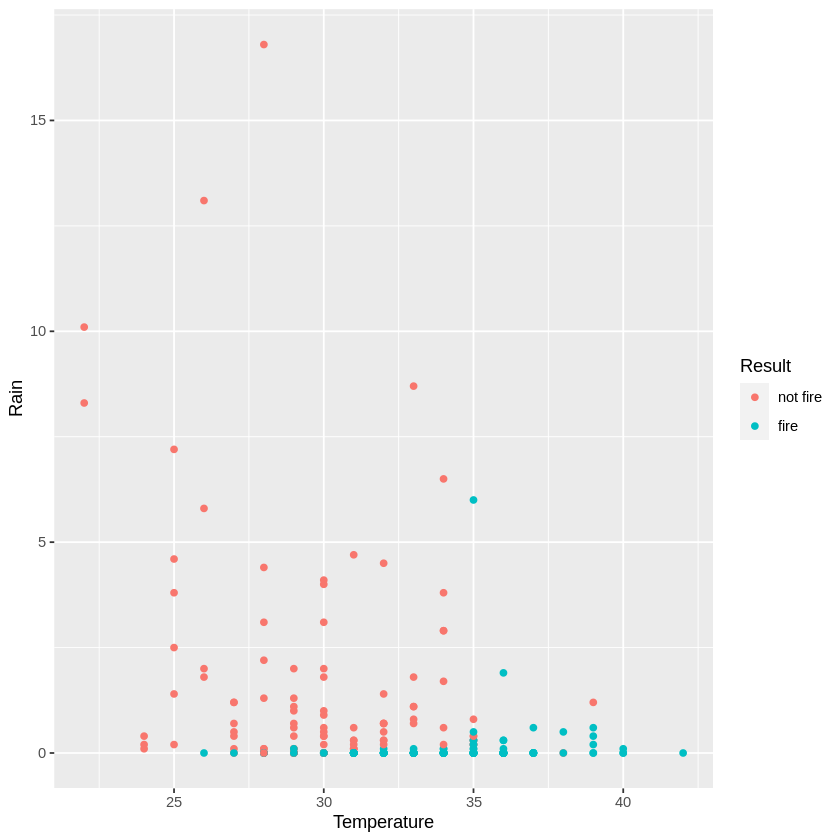

In [42]:
temp_v_rain <- algeria_forest_fire_all_data %>%
    ggplot(aes(x = Temperature, y = Rain, color = Classes)) + 
    geom_point() +
    labs (x = "Temperature", y = "Rain", color = "Result") #weird title for color

temp_v_rain

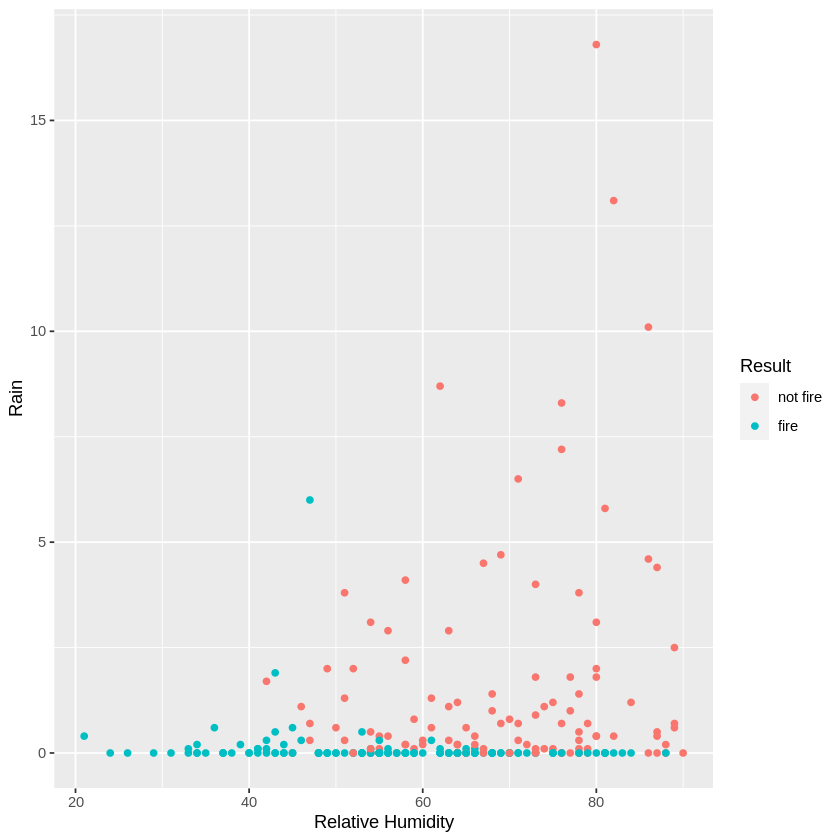

In [48]:
humidity_v_rain <- algeria_forest_fire_all_data %>%
    ggplot(aes(x = RH, y = Rain, color = Classes)) + 
    geom_point() +
    labs (x = "Relative Humidity", y = "Rain", color = "Result") #weird title for color

humidity_v_rain

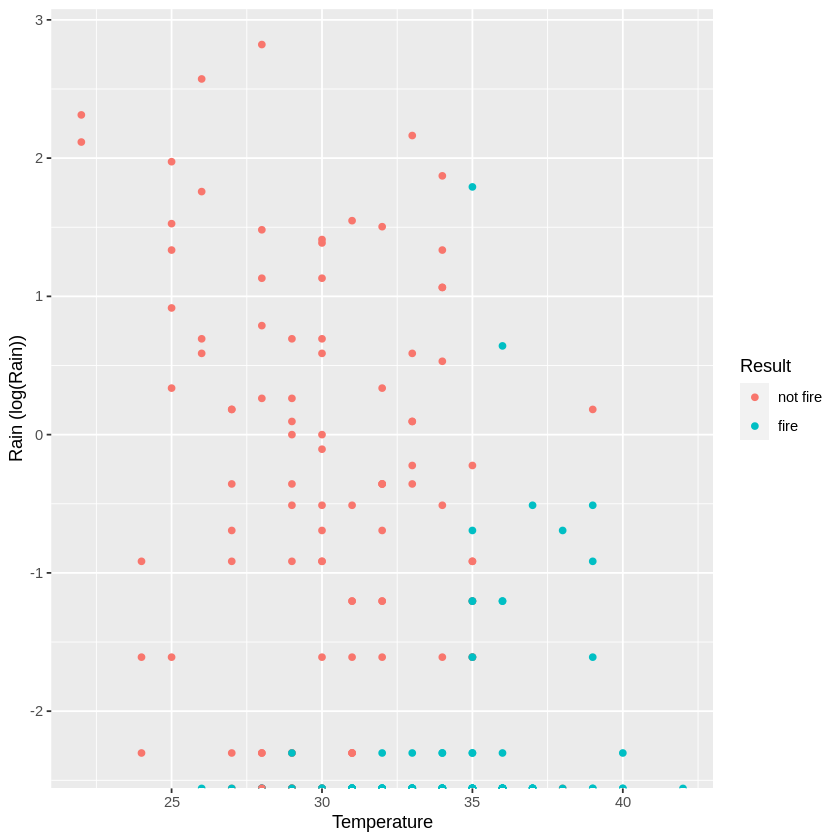

In [50]:
algeria_forest_fire_all_data <- mutate(algeria_forest_fire_all_data, log_rain = log(Rain))


temp_v_rain2 <- algeria_forest_fire_all_data %>%
    ggplot(aes(x = Temperature, y = log_rain, color = Classes)) + 
    geom_point() +
    labs (x = "Temperature", y = "Rain (log(Rain))", color = "Result") #weird title for color

temp_v_rain2

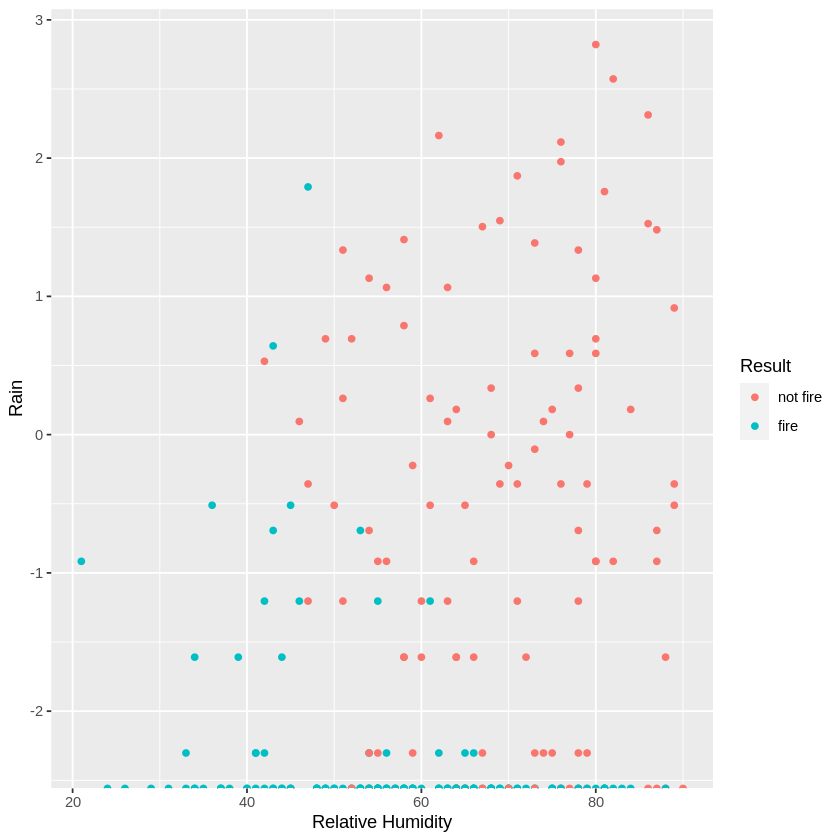

In [51]:
humidity_v_rain2 <- algeria_forest_fire_all_data %>%
    ggplot(aes(x = RH, y = log_rain, color = Classes)) + 
    geom_point() +
    labs (x = "Relative Humidity", y = "Rain", color = "Result") #weird title for color

humidity_v_rain2

In [4]:
# temp_v_rain <- algeria_forest_fire_all_data %>%
#     ggplot(aes(x = Temperature, y = Rain, color = Classes)) + 
#     geom_point() +
#     labs (x = "Temperature", y = "Rain", color = "Result") #weird title for color

# temp_v_rain

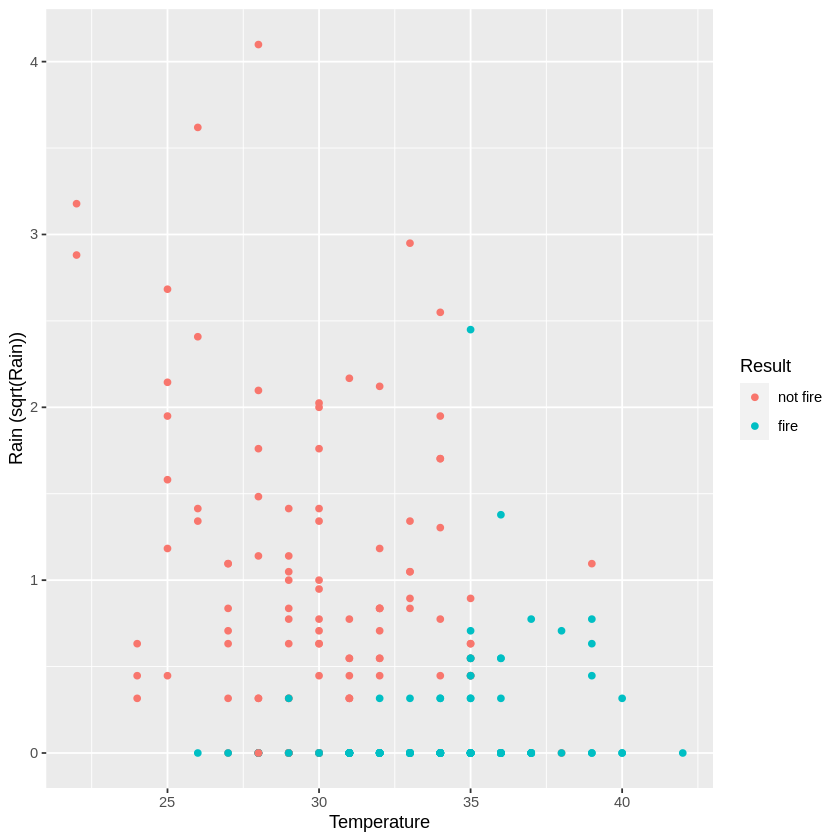

In [5]:
algeria_forest_fire_all_data <- mutate(algeria_forest_fire_all_data, sqrt_rain = sqrt(Rain))


temp_v_rain3 <- algeria_forest_fire_all_data %>%
    ggplot(aes(x = Temperature, y = sqrt_rain, color = Classes)) + 
    geom_point() +
    labs (x = "Temperature", y = "Rain (sqrt(Rain))", color = "Result") #weird title for color

temp_v_rain3

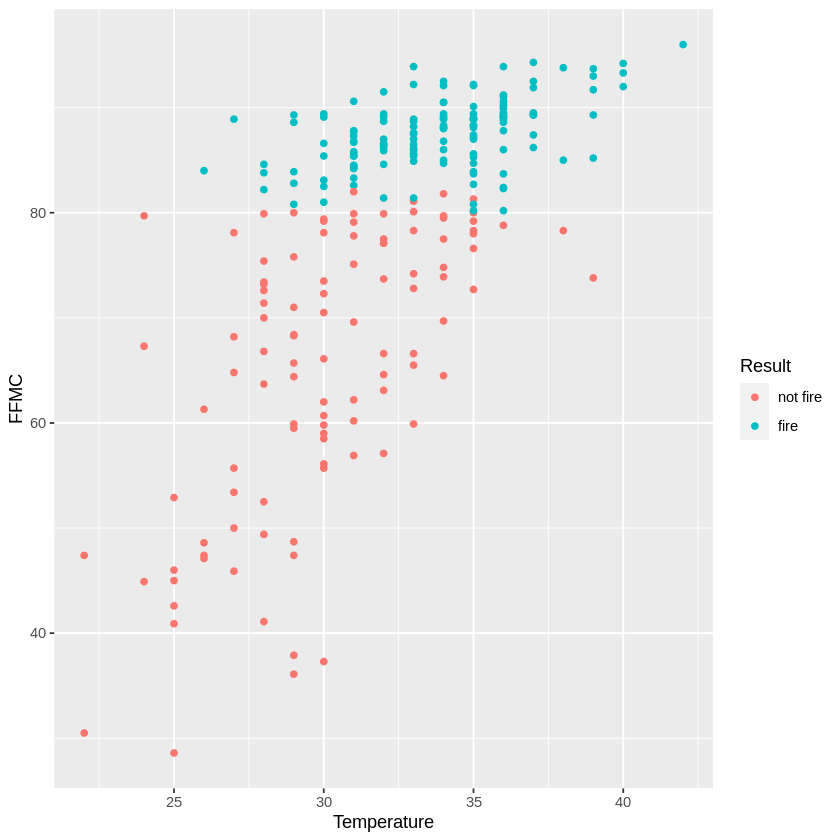

In [41]:
temp_v_ffmc <- algeria_forest_fire_all_data %>%
    ggplot(aes(x = Temperature, y = FFMC, color = Classes)) + 
    geom_point() +
    labs (x = "Temperature", y = "FFMC", color = "Result") #weird title for color

temp_v_ffmc

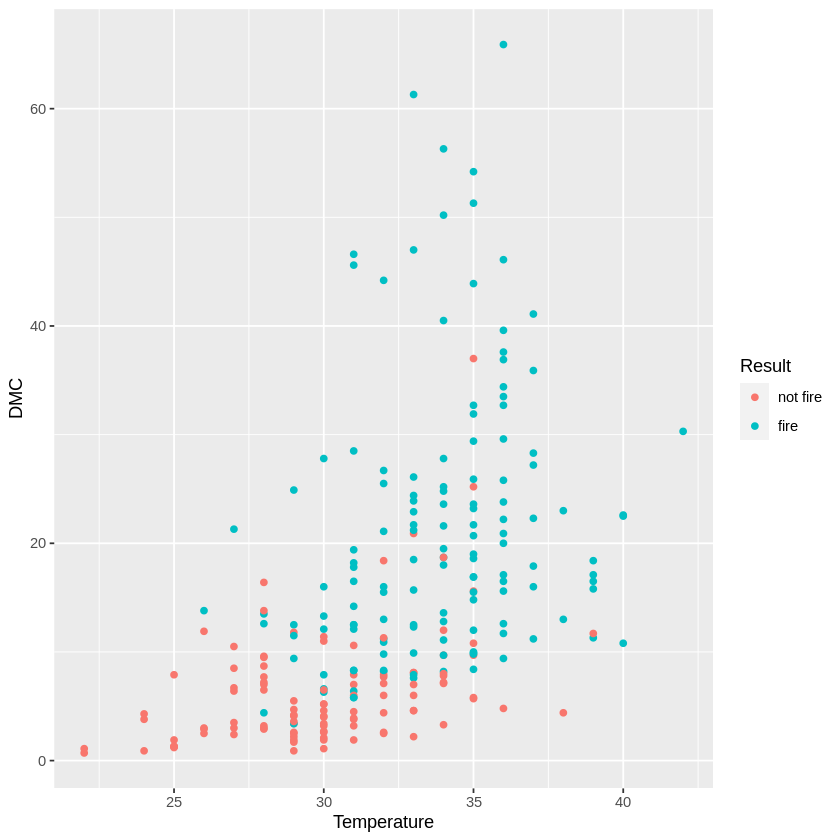

In [43]:
temp_v_dmc <- algeria_forest_fire_all_data %>%
    ggplot(aes(x = Temperature, y = DMC, color = Classes)) + 
    geom_point() +
    labs (x = "Temperature", y = "DMC", color = "Result") #weird title for color

temp_v_dmc

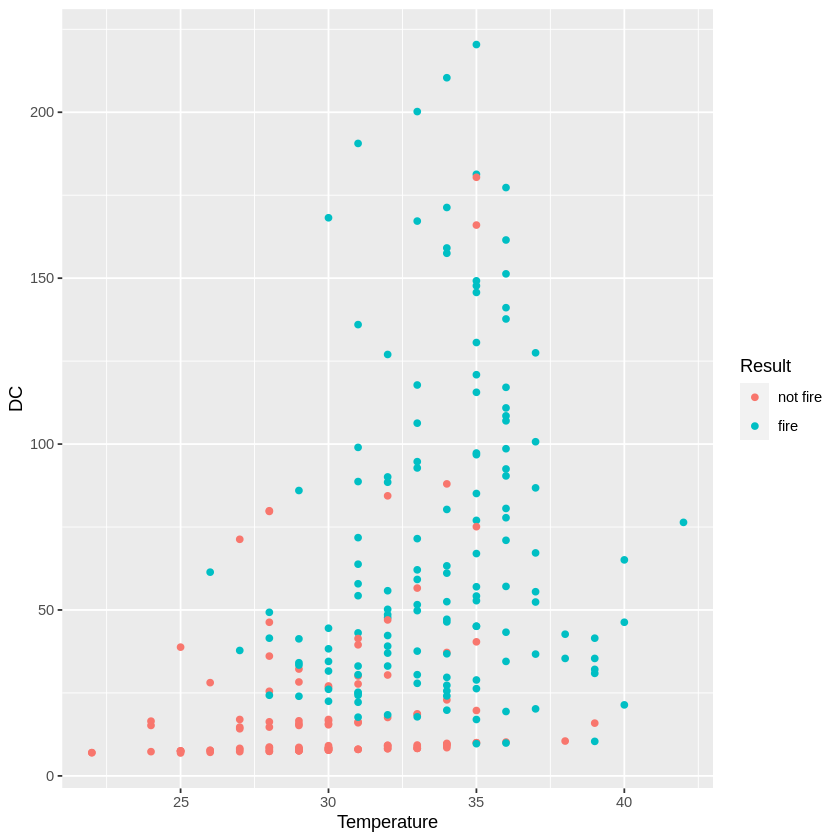

In [44]:
temp_v_DC <- algeria_forest_fire_all_data %>%
    ggplot(aes(x = Temperature, y = DC, color = Classes)) + 
    geom_point() +
    labs (x = "Temperature", y = "DC", color = "Result") #weird title for color

temp_v_DC

In [26]:
set.seed(1)

algeria_forest_fire_all_data_scaled <- algeria_forest_fire_all_data %>% 
mutate(scaled_temp = scale(Temperature, center = TRUE), 
       scaled_sqrt_rain = scale(sqrt_rain, center = TRUE),
       scaled_rh = scale(RH, center = TRUE),
       scaled_ws = scale(Ws, center = TRUE))

#splitting data
fire_split <- initial_split(algeria_forest_fire_all_data_scaled, prop = 0.75, strata = Classes)  
fire_train <- training(fire_split)   
fire_test <- testing(fire_split)

#recipe
fire_recipe_1 <- recipe(Classes ~ scaled_temp + scaled_sqrt_rain, data = fire_train) 
fire_recipe_2 <- recipe(Classes ~ scaled_temp + scaled_sqrt_rain + scaled_rh, data = fire_train) 
fire_recipe_3 <- recipe(Classes ~ scaled_temp + scaled_sqrt_rain + scaled_rh + scaled_ws, data = fire_train) 

#vfold
fire_vfold <- vfold_cv(fire_train, v = 5, strata = Classes)

#tuning model
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
  set_engine("kknn") %>%
  set_mode("classification")

In [27]:
knn_results_1 <- workflow() %>%
    add_recipe(fire_recipe_1) %>%
    add_model(knn_tune) %>%
    tune_grid(resamples = fire_vfold, grid = 15) %>%
    collect_metrics()

accuracies_1 <- knn_results_1 %>% 
      filter(.metric == "accuracy")

cross_val_plot_1 <- ggplot(accuracies_1, aes(x = neighbors, y = mean)) +
      geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate", title="Rain + Temp") +
      scale_x_continuous(breaks = seq(0, 14, by = 1)) +  # adjusting the x-axis
      scale_y_continuous(limits = c(0.4, 1.0)) # adjusting the y-axis

In [28]:
knn_results_2 <- workflow() %>%
    add_recipe(fire_recipe_2) %>%
    add_model(knn_tune) %>%
    tune_grid(resamples = fire_vfold, grid = 15) %>%
    collect_metrics()

accuracies_2 <- knn_results_2 %>% 
      filter(.metric == "accuracy")

cross_val_plot_2 <- ggplot(accuracies_2, aes(x = neighbors, y = mean)) +
      geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate", title="Rain + Temp + Humidity") +
      scale_x_continuous(breaks = seq(0, 14, by = 1)) +  # adjusting the x-axis
      scale_y_continuous(limits = c(0.4, 1.0)) # adjusting the y-axis

In [29]:
knn_results_3 <- workflow() %>%
    add_recipe(fire_recipe_3) %>%
    add_model(knn_tune) %>%
    tune_grid(resamples = fire_vfold, grid = 15) %>%
    collect_metrics()

accuracies_3 <- knn_results_3 %>% 
      filter(.metric == "accuracy")

cross_val_plot_3 <- ggplot(accuracies_3, aes(x = neighbors, y = mean)) +
      geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate", title="Rain + Temp + Humidity + Windspeed") +
      scale_x_continuous(breaks = seq(0, 14, by = 1)) +  # adjusting the x-axis
      scale_y_continuous(limits = c(0.4, 1.0)) # adjusting the y-axis

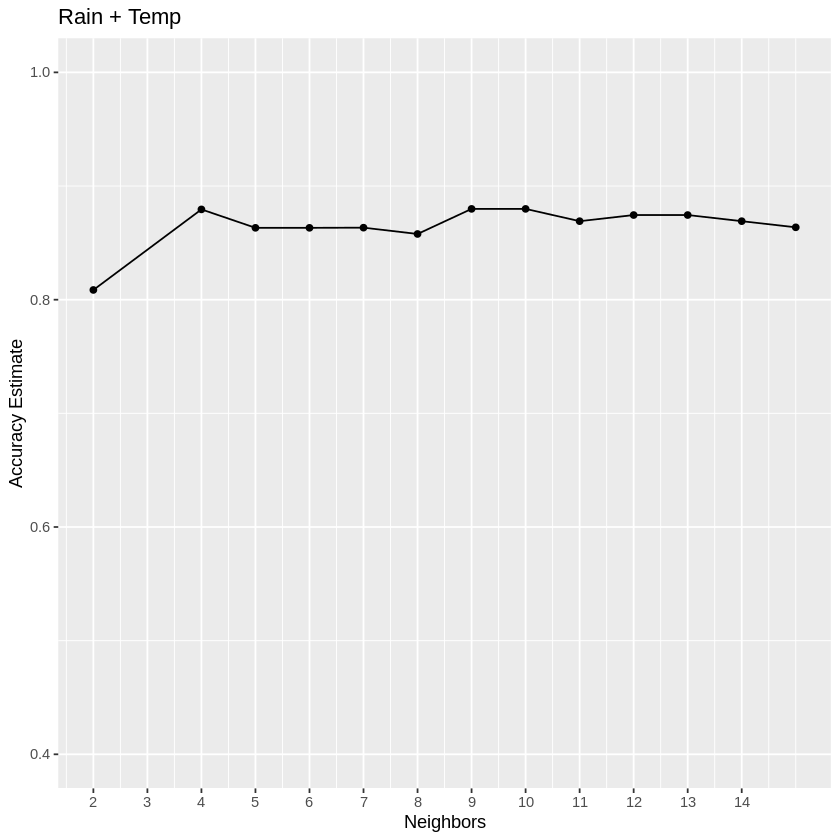

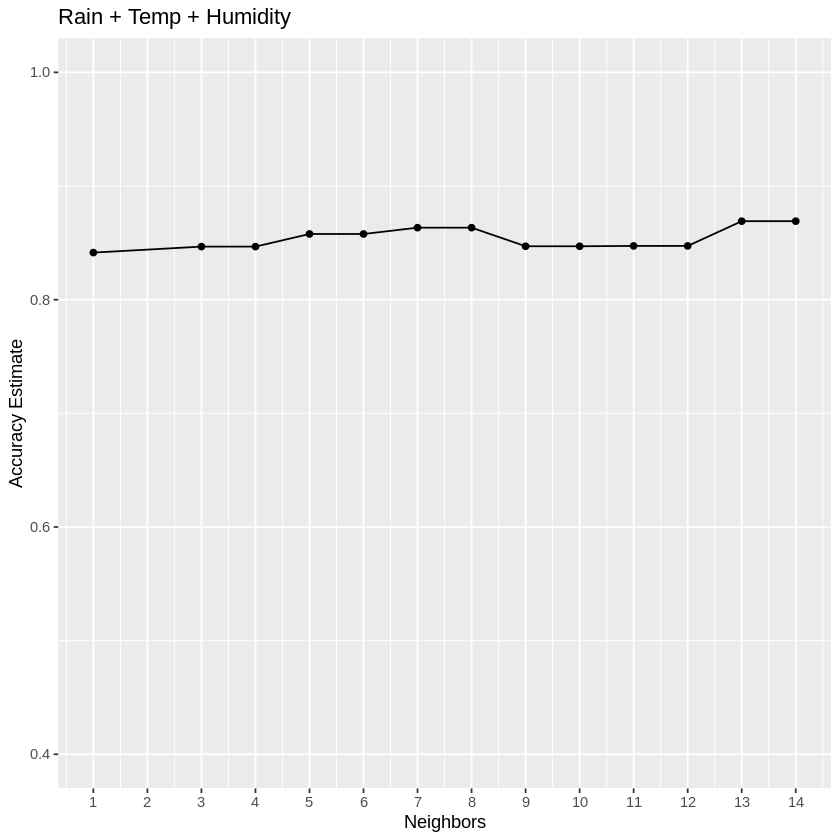

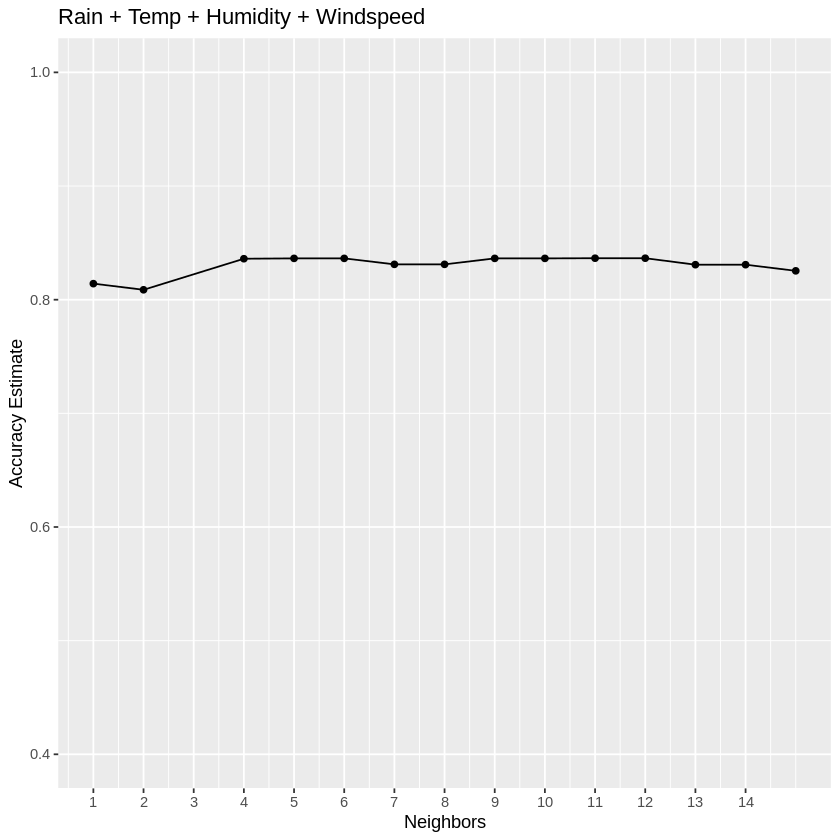

In [37]:
cross_val_plot_1
cross_val_plot_2 
cross_val_plot_3 

We decided on on the first recipe with only two predictors, as it had the highest average accuracies, as well as the highest peaks in accuracy. From there, a neighbour value of 9 was chosen, as it was one of the peaks in accuracy, while also having miniman change when increasing the neighbours to 10 or decreasing the neighbours to 8.

In [38]:
#final_model
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 9) %>%
      set_engine("kknn") %>%
      set_mode("classification")

fire_fit <- workflow() %>%
    add_recipe(fire_recipe_1) %>%
      add_model(knn_spec) %>%
      fit(data = fire_train)

fire_predictions <- predict(fire_fit, fire_test) %>%
    bind_cols(fire_test)

fire_metrics <- fire_predictions %>%
    metrics(truth = Classes, estimate = .pred_class)

fire_conf_mat <- fire_predictions %>%
    conf_mat(truth = Classes, estimate = .pred_class)

fire_metrics
fire_conf_mat


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.850000
kap,binary,0.690367


          Truth
Prediction not fire fire
  not fire       20    3
  fire            6   31